# TP4: Descriptive functions

## Winter 2023 - BIN710 Data Mining (UdeS)

Fourth assignement as part of the Data Mining class at UdeS.

Student name : Simon Lalonde

### Directory structure

├── TP4_data.csv    ---> Data

├── TP4_soln.ipynb   ---> Jupyter Notebook

└── TP4.pdf    ---> Tasks to complete

### Data
1 file
- 900 objects
- 1 attributes (sequence of nucleotides)
- 1 identifier
- No known-classes/labels

### Goal
Compare and use partitionning methods on sequential data. In this case, we are dealing with clustering of RNA sequencing data.

---

## Necessary libraries

In [1]:
from pathlib import Path
import itertools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## 0. Data pre-processing (incoherences) and feature generation (sequence length)

### Loading the data and exploring incongruencies

In [2]:
# dir/file setup and read
tp4_dir = Path.cwd()
filename = "TP4_data.csv"

df = pd.read_csv(tp4_dir / filename)
df.head()

,id,sequence
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...


In [3]:
# Expecting str types OK
print(df.dtypes)

id          object
sequence    object
dtype: object


Checking for possible incongruencies

In [4]:
df["sequence"].head()

0    CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...
1    UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...
2    GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...
3    CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...
4    UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...
Name: sequence, dtype: object

In [5]:
# Biologically possible nucleotides for RNA
possible_nuc = ["C", "U", "A", "G"]
print(possible_nuc)

['C', 'U', 'A', 'G']


In [6]:
# Extracting the unique possible values of nucleotides/chars in the dataset
df["sequence"].str.split("").apply(lambda x: list(set([nuc for nuc in x if nuc != ""]))).str.join("").value_counts()

UGAC      893
NUCAG       5
SUCKAG      1
UMCAG       1
Name: sequence, dtype: int64

**We see that there are a few sequences with incongruencies in the value of individual char/nucleotides i.e. (nucleotides with letters of K, M and S).**

**In the context of DNA/RNA sequencing, "N" represents an unknown/undetermined value so it is expected that some objects might contain N's.**

Checking for lowercase

In [7]:
print(f"Number of lowercase characters: {df['sequence'].str.islower().sum()}")

Number of lowercase characters: 0


In [8]:
rna_nuc_with_unknowns = ["C", "U", "A", "G", "N"]

In [9]:
print(f'{len(df[df["sequence"].apply(lambda x: any(nuc not in possible_nuc for nuc in x))])} samples with nucleotides other than {possible_nuc}')

7 samples with nucleotides other than ['C', 'U', 'A', 'G']


Checking for the 2 samples with mislabelled N's (other chars than UCAGN)

In [10]:
df[df["sequence"].apply(lambda x: any(nuc not in rna_nuc_with_unknowns for nuc in x))]

,id,sequence
53,AM462844.1/17936-17742,UUGUGGAAGAAGGAGCUCUCUUUAGUCCAGUCCGAGACAGCUUCAA...
145,AM457512.2/2227-2039,AGGGGCUUGUGGGAGCUUCUUUACACUCCAGAACUGAAAGGAGAUA...


In [11]:
df[df["sequence"].apply(lambda x: any(nuc not in rna_nuc_with_unknowns for nuc in x))]["sequence"].str.split("").apply(lambda x: list(set([nuc for nuc in x if nuc != ""]))).str.join("")

53     SUCKAG
145     UMCAG
Name: sequence, dtype: object

In [12]:
df[df["sequence"].apply(lambda x: any(nuc not in rna_nuc_with_unknowns for nuc in x))]

,id,sequence
53,AM462844.1/17936-17742,UUGUGGAAGAAGGAGCUCUCUUUAGUCCAGUCCGAGACAGCUUCAA...
145,AM457512.2/2227-2039,AGGGGCUUGUGGGAGCUUCUUUACACUCCAGAACUGAAAGGAGAUA...


Let's write a function to change any non-nucleotide chars to "N"

In [13]:
def replace_mislabelled_nuc(df: pd.DataFrame, col_name_seq: str, possible_nucleotides: list, replacement_nuc: str) -> pd.DataFrame:
    """
    Replaces mislabelled nucleotides in a given column of a DataFrame with a specified replacement nucleotide.

    Args:
        df (pd.DataFrame): The input DataFrame containing the column with nucleotide sequences.
        col_name_seq (str): The name of the column containing the nucleotide sequences.
        possible_nucleotides (list): A list of possible nucleotides. Any nucleotide not in this list is considered mislabelled.
        replacement_nuc (str): The replacement nucleotide to use for mislabelled nucleotides.

    Returns:
        pd.DataFrame: The modified DataFrame with mislabelled nucleotides replaced.

    """
    # Find all mislabelled nucleotides possibilites and save to list
    mislabelled_samples = df[df[col_name_seq].apply(lambda x: any(nuc not in possible_nucleotides for nuc in x))]
    unique_nucs = list(set("".join(mislabelled_samples[col_name_seq].to_list())))
    mislabelled_nucs = [nuc for nuc in unique_nucs if nuc not in possible_nucleotides]
    print(f"All mislabelled nucleotides present in data: {mislabelled_nucs}\n")


    # Loop through list of mislabelled nucleotides
    print("Replacing with N's...")
    for nuc in mislabelled_nucs:
        df["sequence"] = df["sequence"].str.replace(nuc, replacement_nuc)

    return df

In [14]:
# Replacing mislabelled nucs in the df
replace_mislabelled_nuc(
    df=df,
    col_name_seq="sequence",
    possible_nucleotides=rna_nuc_with_unknowns,
    replacement_nuc="N"
)


All mislabelled nucleotides present in data: ['S', 'M', 'K']

Replacing with N's...


,id,sequence
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...
...,...,...
895,URS0000D6890F_1069618/1-62,CAUCUAUAGUUUCAGACAUGGAAUCGCCGAAAACGUCGGCGGUAAA...
896,ACLT01000067.1/45633-45455,AAUAACUGAUUGACUGAAAGUAGGAAUUAAAGCCGUCAAGUUGAGC...
897,URS0000D6BC2B_12908/1-161,UCCGUCAGCUAAUGGCAAUUAGACUGCUGAACUUAAACUGCAUAAG...
898,URS0000D6B588_12908/1-186,GCGAGAAUGUCUACACACCACGGUGGUAGGCAGAGUGUAUUUGUAA...


In [15]:
# Sanity check
print(f'{len(df[df["sequence"].apply(lambda x: any(nuc not in rna_nuc_with_unknowns for nuc in x))])} samples with nucleotides other than {possible_nuc}')

0 samples with nucleotides other than ['C', 'U', 'A', 'G']


### a) Generating the sequence length feature

In [16]:
df["sequence_length"] = df["sequence"].str.len()

In [17]:
df.head()

,id,sequence,sequence_length
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...,207
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...,198
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...,215
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...,222
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...,58


In [18]:
df["sequence"].apply(lambda x: x.count("A")/len(x)*100)

0      22.222222
1      26.262626
2      26.511628
3      24.774775
4      20.689655
         ...    
895    32.258065
896    36.312849
897    33.540373
898    27.419355
899    17.346939
Name: sequence, Length: 900, dtype: float64

I might also look at the individual A, C, G, U and N %content

In [19]:
def get_nuc_counts(df: pd.DataFrame, col_name_seq: str, possible_nucleotides_tocount: list) -> pd.DataFrame:
    """
    Calculates the percentage content of each nucleotide in a given column of a DataFrame and adds the results as new columns.

    Args:
        df (pd.DataFrame): Input DataFrame containing sequence data.
        col_name_seq (str): Column name in df containing the sequences.
        possible_nucleotides_tocount (list): List of possible nucleotides to count.

    Returns:
        pd.DataFrame: DataFrame with added columns for percentage content of each nucleotide.

    Raises:
        ValueError: If data contains nucleotides other than those specified in possible_nucleotides_tocount.
    """
    # Check for invalid nucleotides
    if len(df[df[col_name_seq].apply(lambda x: any(nuc not in possible_nucleotides_tocount for nuc in x))]) > 0:
        raise ValueError(f"Data contains nucleotides other than {possible_nucleotides_tocount}")
    
    # Loop through each nucleotides to count
    for nuc in possible_nucleotides_tocount:
        print(f"Calculatting %{nuc} content and saving to df")
        df[f"%{nuc}_content"] = df[col_name_seq].apply(lambda x: x.count(nuc)/len(x)*100)


In [20]:
# Getting %nucleotide content for each sequence and saving to new column
get_nuc_counts(df=df, col_name_seq="sequence", possible_nucleotides_tocount=rna_nuc_with_unknowns)

Calculatting %C content and saving to df
Calculatting %U content and saving to df
Calculatting %A content and saving to df
Calculatting %G content and saving to df
Calculatting %N content and saving to df


In [21]:
df.head()

,id,sequence,sequence_length,%C_content,%U_content,%A_content,%G_content,%N_content
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...,207,29.468599,19.806763,22.222222,28.502415,0.0
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...,198,23.737374,26.767677,26.262626,23.232323,0.0
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...,215,24.186047,24.186047,26.511628,25.116279,0.0
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...,222,24.774775,24.774775,24.774775,25.675676,0.0
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...,58,24.137931,24.137931,20.689655,31.034483,0.0


## 1. Data partitionning based on sequence length distributions

### Explore the distributions 

In [22]:
# Check distributions
def get_distributions(data, features, plt_rows, plt_cols, feat_color=True, hue=None, bins='auto', binwidth=None, kde=True):
    # Square subplots
    fig, axes = plt.subplots(plt_rows, plt_cols, figsize=(8,10))
    axes = axes.ravel()

    for i, feat in enumerate(features):
        if feat_color:
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=sns.color_palette()[i])
        else :
            feat_color = None
            plot = sns.histplot(data=data, x=feat, kde=kde, ax=axes[i], hue=hue, bins=bins, binwidth=binwidth, color=feat_color)
        plot.set(title=f"Distribution for : {feat}")
        plot.set(xlabel="")

    fig.tight_layout()

In [23]:
df.columns[2:]

Index(['sequence_length', '%C_content', '%U_content', '%A_content',
       '%G_content', '%N_content'],
      dtype='object')

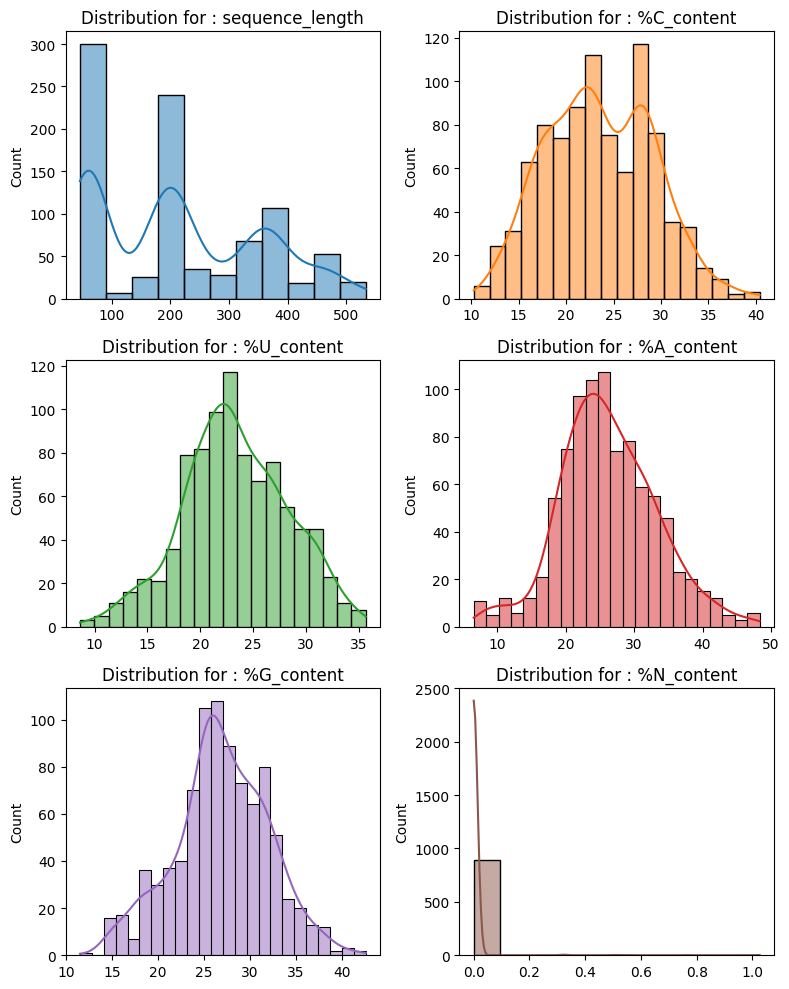

In [24]:
get_distributions(
    data=df,
    features=df.columns[2:],
    plt_rows=3,
    plt_cols=2,
)

Looking like normal distributions for the %content of all nucleotides except for the C content

**Let's explore the sequence length with a thinner binwidth since it is the feature we are the most interested in and we want to partition the data based on this feature**

[Text(0.5, 0, '')]

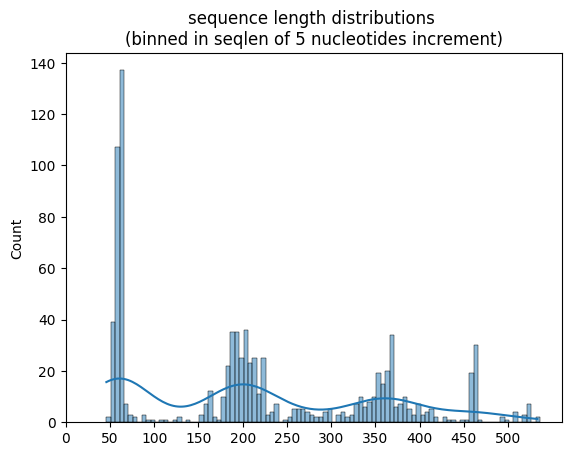

In [25]:
# Explore sequence length distribution with thinner bins
ax = sns.histplot(data=df, x="sequence_length", kde=True, bins="auto", binwidth=5)
ax.set_xticks(range(0, max(df["sequence_length"]), 50))
ax.set(title="sequence length distributions \n(binned in seqlen of 5 nucleotides increment)")
ax.set(xlabel="")

**Looking at the distributions, I propose that we split the data into 4 groups of different lengths :**

1. small: sm (seqlen < 150 bp)
2. medium: md  (150 bp <= seqlen < 300 bp)
3. long: ln (300 bp <= seqlen < 450 bp)
4. very-long: vl (seqlen >= 450 bp) 

In [26]:
df["sequence_length"].head()

0    207
1    198
2    215
3    222
4     58
Name: sequence_length, dtype: int64

### b) Assign the classes based on the distributions peak (label encoding by binning of continuous data)

Again, based on the four distinct peaks in the distributions, we will assign a class number corresponding to the length of the sequence:
- 0 = sm
- 1 = md
- 2 = ln
- 3 = vl

In [27]:
#TODO FUNCTION TO GET CUTOFFS AND SAVE TO COL + CHECK CLASS BALANCING
def filter_seqlen(x):
    """
    Apply condition on the sequence length and return a class label according to the value of x

    Args:
        x (int): Int number to apply the check the conditions on

    Returns:
        int: Class from 0 to 3 (from smallest to largest)
    """
    if x < 150:
        return 0
    elif 150 <= x < 300:
        return 1
    elif 300 <= x < 450:
        return 2
    else:
        return 3


def assign_class(df: pd.DataFrame, col_name_seqlen: str) -> pd.DataFrame:
    """
    Assign a class based on the sequence length of the nc-RNA

    Args:
        df (pd.DataFrame): Dataframe with the sequence length feature
        col_name_seqlen (str): Name of the column corresponding to the sequence length feature

    Returns:
        pd.DataFrame: _description_
    """
    
    df["seqlen_class"] =  df[col_name_seqlen].apply(filter_seqlen)
    return df


In [28]:
# Assign class based on distributions
assign_class(df=df, col_name_seqlen="sequence_length")

,id,sequence,sequence_length,%C_content,%U_content,%A_content,%G_content,%N_content,seqlen_class
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...,207,29.468599,19.806763,22.222222,28.502415,0.0,1
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...,198,23.737374,26.767677,26.262626,23.232323,0.0,1
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...,215,24.186047,24.186047,26.511628,25.116279,0.0,1
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...,222,24.774775,24.774775,24.774775,25.675676,0.0,1
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...,58,24.137931,24.137931,20.689655,31.034483,0.0,0
...,...,...,...,...,...,...,...,...,...
895,URS0000D6890F_1069618/1-62,CAUCUAUAGUUUCAGACAUGGAAUCGCCGAAAACGUCGGCGGUAAA...,62,22.580645,19.354839,32.258065,25.806452,0.0,0
896,ACLT01000067.1/45633-45455,AAUAACUGAUUGACUGAAAGUAGGAAUUAAAGCCGUCAAGUUGAGC...,179,15.083799,24.581006,36.312849,24.022346,0.0,1
897,URS0000D6BC2B_12908/1-161,UCCGUCAGCUAAUGGCAAUUAGACUGCUGAACUUAAACUGCAUAAG...,161,16.770186,25.465839,33.540373,24.223602,0.0,1
898,URS0000D6B588_12908/1-186,GCGAGAAUGUCUACACACCACGGUGGUAGGCAGAGUGUAUUUGUAA...,186,23.118280,26.881720,27.419355,22.580645,0.0,1


In [29]:
# Validating our classes
df[["sequence_length", "seqlen_class"]].head(15)

,sequence_length,seqlen_class
0,207,1
1,198,1
2,215,1
3,222,1
4,58,0
5,55,0
6,224,1
7,61,0
8,64,0
9,60,0


## 2. Data partitionning based on vector representation of sequences for each seqlen groups

### A) Vectorial representation
For each of the 4 groups, we need to generate a binary vector representation of n-dims, with n being all possible k={2..4} mers.

First, we need to get all the possible k-mers with k={2..4}

In [30]:
def generate_rna_kmers(possible_nucleotides: list, kmin: int, kmax: int):
    # Validate rna nucleotides
    rna_nuc_with_unknowns = ['C', 'U', 'A', 'G', 'N']
    for nuc in possible_nucleotides:
        if nuc not in rna_nuc_with_unknowns:
            raise ValueError(f"{nuc} is not a valid RNA nucleotide")
    
    # Validate k type
    try:
        kmin = int(kmin)
    except:
        raise TypeError("kmin must be an integer")
    try:
        kmax = int(kmax)
    except:
        raise TypeError("kmax must be an integer.")
    
    # Validate kmin range:
    if kmin < 1:
        raise ValueError("kmin must be greater than 0")
    elif kmin > kmax:
        raise ValueError("kmin must be smaller than kmax")
    
    # Validate kmax range
    if kmax > len(possible_nucleotides):
        raise ValueError(f"kmax must be smaller than {len(possible_nucleotides)}")

    # Generate all possible kmers
    kmers = {}
    
    for k in range(kmin, kmax + 1):
        kmers[f"kmers-{k}"] = [''.join(nuc) for nuc in itertools.product(possible_nucleotides, repeat=k)]

    return kmers

In [31]:
# Generate all kmers for k e {2, 3, 4}
kmers = generate_rna_kmers(possible_nucleotides=rna_nuc_with_unknowns, kmin=2, kmax=4)

In [32]:
print(f"K-mers generated: {list(kmers.keys())}\n")
print(f'Exmaple with all 2-mers: \n{kmers["kmers-2"]}')

K-mers generated: ['kmers-2', 'kmers-3', 'kmers-4']

Exmaple with all 2-mers: 
['CC', 'CU', 'CA', 'CG', 'CN', 'UC', 'UU', 'UA', 'UG', 'UN', 'AC', 'AU', 'AA', 'AG', 'AN', 'GC', 'GU', 'GA', 'GG', 'GN', 'NC', 'NU', 'NA', 'NG', 'NN']


Then we can generate initialize the vector of all k-mers into our dataframe. First we generate an empty kmers dataframe and concat with our original df

In [34]:
# Get kmers dataframe
kmer_patterns = [kmer for k in kmers for kmer in kmers[k]]
kmers_df = pd.DataFrame(0, index=df.index, columns=kmer_patterns)

# Concat to the original dataframe
df = pd.concat([df, kmers_df], axis=1)

In [35]:
df.head()

,id,sequence,sequence_length,%C_content,%U_content,%A_content,%G_content,%N_content,seqlen_class,CC,...,NNGC,NNGU,NNGA,NNGG,NNGN,NNNC,NNNU,NNNA,NNNG,NNNN
0,AAIY01303410.1/717-923,CCAACGUGGAUACUCCCGGGAGGUCACUCUCCCCGGGCUCUGUCCA...,207,29.468599,19.806763,22.222222,28.502415,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,CP000140.1/4143906-4143709,UACCUUUGCAUCCGAAUUGGUUCCGUACGCUCGUUCGGGCAUACGG...,198,23.737374,26.767677,26.262626,23.232323,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,URS0000D6BCE7_12908/1-215,GCGUAACGCGCUAUGGCUUAAACGGCUGCCCCAAAGCUGCCAAAGG...,215,24.186047,24.186047,26.511628,25.116279,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,X71081.1/4425-4646,CCAAUGUGGAUAUCCUUAGAGGUCUCUCUUGGGCUCUGUCCAGGUG...,222,24.774775,24.774775,24.774775,25.675676,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,AACY020770731.1/455-512,UUUCGUUCACCCUCAAUUGAGGGCGCAGUUCGAGUCAUACCAUGGA...,58,24.137931,24.137931,20.689655,31.034483,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# Iterate through each possible kmer and count the occurences
for kmer in kmer_patterns:
    df[kmer] = df["sequence"].apply(lambda seq: seq.count(kmer))

In [54]:
df[kmer_patterns].head()

,CC,CU,CA,CG,CN,UC,UU,UA,UG,UN,...,NNGC,NNGU,NNGA,NNGG,NNGN,NNNC,NNNU,NNNA,NNNG,NNNN
0,16,15,19,7,0,14,4,4,17,0,...,0,0,0,0,0,0,0,0,0,0
1,12,12,11,11,0,14,12,14,9,0,...,0,0,0,0,0,0,0,0,0,0
2,8,12,16,14,0,7,16,7,17,0,...,0,0,0,0,0,0,0,0,0,0
3,15,13,18,4,0,13,10,14,16,0,...,0,0,0,0,0,0,0,0,0,0
4,2,1,5,4,0,5,4,1,3,0,...,0,0,0,0,0,0,0,0,0,0
